In [1]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from keras import layers
from keras import models
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [3]:
def get_clf_eval(y_test,pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred, average = 'macro')
    recall = recall_score(y_test,pred, average = 'macro')
    f1 = f1_score(y_test, pred, average = 'macro')
    roc_auc = roc_auc_score(y_test, pred_proba, average = 'macro', multi_class='ovr')
    print('Confusion matrix')
    print(confusion)
    print('Accuracy:{0:.4f}, Precision:{1:.4f}, Recall:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 1. Load train and test data

In [4]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data['Target'])
labels = encoder.transform(train_data['Target'])
print('Encoded labels:', labels)

Encoded labels: [2 1 0 ... 2 2 2]


In [6]:
encoder.classes_

array(['GA', 'HO', 'LO', 'QMD'], dtype=object)

In [7]:
train_data['Target'] = labels

### 2. Reshape the train data

In [8]:
X_train = train_data.iloc[:,:2048]
y_train = train_data.iloc[:,2048]

X_test = test_data.iloc[:,:2048]
y_test = test_data.iloc[:,2048]

In [9]:
n_features = 2048 
n_class = 4

X_train_r = np.zeros((len(X_train), n_features, 1))   
X_test_r = np.zeros((len(X_test), n_features, 1))

In [10]:
X_train.shape

(7200, 2048)

In [11]:
X_train_r[:,:,0] = X_train[:]
X_test_r[:,:,0] = X_test[:]

In [12]:
X_train_r.shape

(7200, 2048, 1)

In [13]:
X_train_r

array([[[ 0.],
        [22.],
        [31.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [11.],
        [22.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [15.],
        [28.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       ...,

       [[ 0.],
        [17.],
        [23.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [16.],
        [23.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [14.],
        [28.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]]])

### 3. Configure the 1-D CNN model

In [14]:
from keras.utils import np_utils
cross_valid_accuracy = []
order = 0

# Stratified K-Fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
input_shape = (5, 2048, 1)

for train, valid in skf.split(X_train_r, y_train):
        
    order = order + 1
        
    print("The order of 5-fold cross-validation:", order)
        
    strat_k_train_set = X_train_r[train]
    strat_k_valid_set = X_train_r[valid]

    # X_train, y_train, X_valid, y_valid 
    X_train_f = X_train_r[train]
    X_valid_f = X_train_r[valid]
    y_train_f = y_train[train]
    y_valid_f = y_train[valid]
        
        
    y_train_encoded = np_utils.to_categorical(y_train_f, n_class)
    y_valid_encoded = np_utils.to_categorical(y_valid_f, n_class)
    
    model = Sequential()
    model.add(layers.Conv1D(32, 3, input_shape =input_shape[1:], activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping_callback = EarlyStopping(monitor='loss', patience=100) #verbose=0
    
    model.fit(X_train_f,y_train_encoded, validation_data=(X_valid_f, y_valid_encoded), epochs=5, 
            batch_size=5, callbacks=[early_stopping_callback])
    accuracy = model.evaluate(X_valid_f,y_valid_encoded)[1]
    cross_valid_accuracy.append(accuracy)

The order of 5-fold cross-validation: 1
Epoch 1/5
1152/1152 [==============================] - 9s 8ms/step - loss: 9.4314 - accuracy: 0.8319 - val_loss: 0.1983 - val_accuracy: 0.9500
Epoch 2/5
1152/1152 [==============================] - 9s 8ms/step - loss: 0.3909 - accuracy: 0.9052 - val_loss: 0.3649 - val_accuracy: 0.9167
Epoch 3/5
1152/1152 [==============================] - 9s 8ms/step - loss: 0.2637 - accuracy: 0.9253 - val_loss: 0.1220 - val_accuracy: 0.9639
Epoch 4/5
1152/1152 [==============================] - 9s 8ms/step - loss: 0.2429 - accuracy: 0.9269 - val_loss: 0.1966 - val_accuracy: 0.9347
Epoch 5/5
45/45 [==============================] - 0s 4ms/step - loss: 0.5497 - accuracy: 0.8479
The order of 5-fold cross-validation: 2
Epoch 1/5
1152/1152 [==============================] - 9s 8ms/step - loss: 13.9365 - accuracy: 0.8498 - val_loss: 0.7040 - val_accuracy: 0.8757
Epoch 2/5
1152/1152 [==============================] - 9s 8ms/step - loss: 0.5369 - accuracy: 0.8951 - val_

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 2046, 32)          128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1023, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1023, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32736)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2095168   
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                

In [16]:
cross_valid_accuracy

[0.8479166626930237,
 0.9069444537162781,
 0.9638888835906982,
 0.9541666507720947,
 0.9652777910232544]

In [17]:
# mean of cross validation accuracy
np.mean(cross_valid_accuracy)

0.9276388883590698

### 3. Test the 1-D CNN model

In [18]:
y_train_encoded = np_utils.to_categorical(y_train, n_class)
y_test_encoded = np_utils.to_categorical(y_test, n_class)

model.fit(X_train_r,y_train_encoded, epochs=5, batch_size=5, callbacks=[early_stopping_callback])
accuracy = model.evaluate(X_test_r,y_test_encoded)[1]

print("accuracy for predicting test data: {:.4f}".format(accuracy)) 

Epoch 1/5
1440/1440 [==============================] - 11s 8ms/step - loss: 0.1965 - accuracy: 0.9381
Epoch 2/5
1440/1440 [==============================] - 12s 8ms/step - loss: 0.2118 - accuracy: 0.9314
Epoch 3/5
1440/1440 [==============================] - 11s 8ms/step - loss: 0.1538 - accuracy: 0.9488
Epoch 4/5
1440/1440 [==============================] - 11s 8ms/step - loss: 0.1204 - accuracy: 0.9603
Epoch 5/5
17/17 [==============================] - 0s 4ms/step - loss: 0.2094 - accuracy: 0.9343
accuracy for predicting test data: 0.9343


In [19]:
preds = model.predict(X_test_r)
preds_decod = np.argmax(preds, axis=1).reshape(-1,1)
get_clf_eval(y_test, preds_decod, preds)

Confusion matrix
[[142   0   0  10]
 [  0 132   3   0]
 [ 11   5 104   0]
 [  6   0   0 120]]
Accuracy:0.9343, Precision:0.9379, Recall:0.9328, F1:0.9344, AUC:0.9928


In [20]:
print(metrics.classification_report(y_test, preds_decod, digits=4))

              precision    recall  f1-score   support

           0     0.8931    0.9342    0.9132       152
           1     0.9635    0.9778    0.9706       135
           2     0.9720    0.8667    0.9163       120
           3     0.9231    0.9524    0.9375       126

    accuracy                         0.9343       533
   macro avg     0.9379    0.9328    0.9344       533
weighted avg     0.9358    0.9343    0.9342       533



In [21]:
test_preds = preds_decod.reshape(-1)

### 4. Visualize the results 

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_reduced)
X_test_scaled = StandardScaler().fit_transform(X_test_reduced)

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 10 Text xticklabel objects>)

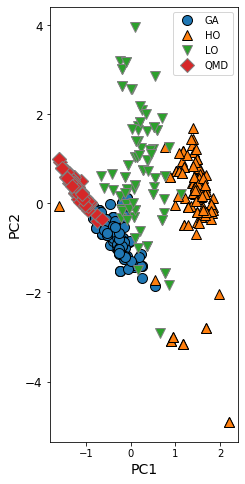

In [23]:
import mglearn

plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_test_scaled[:,0], X_test_scaled[:,1], test_preds)
plt.legend(["GA", "HO", "LO", "QMD"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xticks(fontsize=10)